# EDA & Cleaning - Weather

EDA and cleaning of Spain Weather data. 

**Ongoing**

[Source](https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather)

## Contents

- [Imports](#Imports)
- [Initial Look](#Initial-Look)
- [Temperature](#Temperature)
- [Duplicates](#Duplicates)

### Imports

In [1]:
# General Imports
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import chart_studio.plotly as py 
import plotly.graph_objs as go 
import plotly.express as px

# Missing Data Imports
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Time series imports
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import timedelta

# EDA Import
from EDA import EDA

### Initial Look

In [2]:
weather = pd.read_csv('../Data/energy-consumption-generation-prices-and-weather/weather_features.csv')

weather.head()

dt_iso city_name     temp  temp_min  temp_max  pressure  \
0  2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
1  2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2  2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
3  2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
4  2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686      1002   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0        77           1        62      0.0      0.0      0.0           0   
1        77           1        62      0.0      0.0      0.0           0   
2        78           0        23      0.0      0.0      0.0           0   
3        78           0        23      0.0      0.0      0.0           0   
4        78           0        23      0.0      0.0      0.0           0   

   weather_id weather_main weather_description weather_icon  
0         800        clear        sky is clear          01n  
1         800        clear        sky is clear          01n  
2         800        clear        sky is clear          01n  
3         800        clear        sky is clear          01n  
4         800        clear        sky is clear          01n

In [3]:
weather.shape

(178396, 17)

In [4]:
weather.isnull().sum()

dt_iso                 0
city_name              0
temp                   0
temp_min               0
temp_max               0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
rain_3h                0
snow_3h                0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
weather_icon           0
dtype: int64

No missing values

In [5]:
# data types
weather.dtypes

dt_iso                  object
city_name               object
temp                   float64
temp_min               float64
temp_max               float64
pressure                 int64
humidity                 int64
wind_speed               int64
wind_deg                 int64
rain_1h                float64
rain_3h                float64
snow_3h                float64
clouds_all               int64
weather_id               int64
weather_main            object
weather_description     object
weather_icon            object
dtype: object

In [6]:
# which cities
weather['city_name'].unique()

array(['Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville'],
      dtype=object)

We have data from 5 cities, later we will have to consider how to merge them such that they are all on the same time index.

In [7]:
# Make time columns datetime format
# utc=True to get rid of +01:00's and allow for use 
# as datetime index, but add back the hour to get consistent Spain time
weather['time'] = pd.to_datetime(weather['dt_iso'], utc=True)+timedelta(hours=1)

In [8]:
# are our time's all unique?
weather['time'].nunique()

35064

Good we have the same number of unique times as we did in our energy data.

In [9]:
# set index
weather.set_index('time', inplace=True)

weather.head()

dt_iso city_name     temp  \
time                                                                      
2015-01-01 00:00:00+00:00  2015-01-01 00:00:00+01:00  Valencia  270.475   
2015-01-01 01:00:00+00:00  2015-01-01 01:00:00+01:00  Valencia  270.475   
2015-01-01 02:00:00+00:00  2015-01-01 02:00:00+01:00  Valencia  269.686   
2015-01-01 03:00:00+00:00  2015-01-01 03:00:00+01:00  Valencia  269.686   
2015-01-01 04:00:00+00:00  2015-01-01 04:00:00+01:00  Valencia  269.686   

                           temp_min  temp_max  pressure  humidity  wind_speed  \
time                                                                            
2015-01-01 00:00:00+00:00   270.475   270.475      1001        77           1   
2015-01-01 01:00:00+00:00   270.475   270.475      1001        77           1   
2015-01-01 02:00:00+00:00   269.686   269.686      1002        78           0   
2015-01-01 03:00:00+00:00   269.686   269.686      1002        78           0   
2015-01-01 04:00:00+00:00   269.686   269.686      1002        78           0   

                           wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
time                                                                         
2015-01-01 00:00:00+00:00        62      0.0      0.0      0.0           0   
2015-01-01 01:00:00+00:00        62      0.0      0.0      0.0           0   
2015-01-01 02:00:00+00:00        23      0.0      0.0      0.0           0   
2015-01-01 03:00:00+00:00        23      0.0      0.0      0.0           0   
2015-01-01 04:00:00+00:00        23      0.0      0.0      0.0           0   

                           weather_id weather_main weather_description  \
time                                                                     
2015-01-01 00:00:00+00:00         800        clear        sky is clear   
2015-01-01 01:00:00+00:00         800        clear        sky is clear   
2015-01-01 02:00:00+00:00         800        clear        sky is clear   
2015-01-01 03:00:00+00:00         800        clear        sky is clear   
2015-01-01 04:00:00+00:00         800        clear        sky is clear   

                          weather_icon  
time                                    
2015-01-01 00:00:00+00:00          01n  
2015-01-01 01:00:00+00:00          01n  
2015-01-01 02:00:00+00:00          01n  
2015-01-01 03:00:00+00:00          01n  
2015-01-01 04:00:00+00:00          01n

In [10]:
# make an EDA object to check outliers
clean = EDA(weather)
# all columns except object columns, get 99% outliers 
clean.check_outliers(weather, weather.columns[2:14], 2.58)

{'temp': {'upper outliers': 789, 'lower outliers': 186},
 'temp_min': {'upper outliers': 998, 'lower outliers': 137},
 'temp_max': {'upper outliers': 887, 'lower outliers': 149},
 'pressure': {'upper outliers': 42, 'lower outliers': 0},
 'humidity': {'upper outliers': 0, 'lower outliers': 350},
 'wind_speed': {'upper outliers': 4552, 'lower outliers': 0},
 'wind_deg': {'upper outliers': 0, 'lower outliers': 0},
 'rain_1h': {'upper outliers': 1396, 'lower outliers': 0},
 'rain_3h': {'upper outliers': 994, 'lower outliers': 0},
 'snow_3h': {'upper outliers': 185, 'lower outliers': 0},
 'clouds_all': {'upper outliers': 0, 'lower outliers': 0},
 'weather_id': {'upper outliers': 0, 'lower outliers': 2765}}

We can see that there are numerous outliers, though this is not that surprising. Especially for categories related to precipitation a mojority of the values are likely 0, so having upper outliers is expected. For other categories we need to consider that this includes data from 5 different cities and Spain is a large and varied country geographically so having some outliers is expected.  Let's start looking at the individual categories.

In [11]:
# Drop dt_iso column
weather.drop(columns = ['dt_iso'], inplace=True)

### Temperature

In [12]:
# Get column names
temp_cols = ['temp', 'temp_min', 'temp_max']

In [13]:
# Describe by city
weather.groupby('city_name')[temp_cols].describe().T

city_name          Barcelona        Bilbao        Madrid       Seville  \
temp     count  35476.000000  35951.000000  36267.000000  35557.000000   
         mean     289.848248    286.378489    288.061071    293.105431   
         std        6.712455      6.795776      9.298482      8.065712   
         min      262.240000    266.850000    264.132000    271.050000   
         25%      284.670000    281.390000    281.120000    287.330000   
         50%      289.360000    286.130000    286.580000    292.340000   
         75%      295.150000    291.020000    294.720000    298.760000   
         max      309.150000    312.470000    313.330000    315.600000   
temp_min count  35476.000000  35951.000000  36267.000000  35557.000000   
         mean     288.594704    284.916661    286.824877    291.184103   
         std        6.447358      6.820451      9.159233      8.244529   
         min      262.240000    264.150000    264.132000    269.150000   
         25%      284.150000    280.150000    280.150000    285.150000   
         50%      288.150000    284.647000    285.425000    290.150000   
         75%      293.150000    289.820000    293.150000    296.265000   
         max      307.150000    312.040000    312.150000    315.150000   
temp_max count  35476.000000  35951.000000  36267.000000  35557.000000   
         mean     291.021987    288.036687    289.155600    295.962431   
         std        7.277714      6.971775      9.647888      9.070491   
         min      262.240000    268.978000    264.132000    272.063000   
         25%      285.150000    283.150000    282.150000    289.150000   
         50%      290.150000    288.150000    287.250000    295.150000   
         75%      297.040000    292.150000    296.150000    303.150000   
         max      315.370000    318.710000    316.480000    321.150000   

city_name           Valencia  
temp     count  35145.000000  
         mean     290.780780  
         std        7.231284  
         min      268.830656  
         25%      285.150000  
         50%      290.170000  
         75%      296.150000  
         max      311.150000  
temp_min count  35145.000000  
         mean     290.222277  
         std        7.087512  
         min      268.830656  
         25%      285.150000  
         50%      290.150000  
         75%      295.370000  
         max      311.150000  
temp_max count  35145.000000  
         mean     291.355025  
         std        7.519891  
         min      268.830656  
         25%      285.650000  
         50%      291.150000  
         75%      297.150000  
         max      314.820000

We need to note that the temperature values are in kelvins which renders a scale that we are not used to. 

100 degrees farenheit is approximately 311 degrees kelvin and 32 degrees farenheit is approximately 273 degrees kelvin.

Given that, the highest value of 321 degrees kelvin in Seville is about 118 degrees farenheit, which while extremely hot is reasonable. The lowest value of 262 kelvin in Barcelona is about 12 degrees farenheit and is also a reasonable value, though it is warmer than I would have expected. 

Additionally we can see that each city does not have the same number of observations and furthermore the number of observations are all greater than the 35064 observations we have in the energy data set. Let's see if we have duplicated observations.

### Duplicates

In [19]:
# how many duplicate values
weather.duplicated(keep='first').sum()

8622

It seems that we have 8622 duplicated values, this is obviously an issue

In [15]:
temp_dict = {
    'temp' : 'Temp'
}

city_name
 Barcelona    AxesSubplot(0.125,0.2;0.775x0.68)
Bilbao        AxesSubplot(0.125,0.2;0.775x0.68)
Madrid        AxesSubplot(0.125,0.2;0.775x0.68)
Seville       AxesSubplot(0.125,0.2;0.775x0.68)
Valencia      AxesSubplot(0.125,0.2;0.775x0.68)
Name: temp, dtype: object

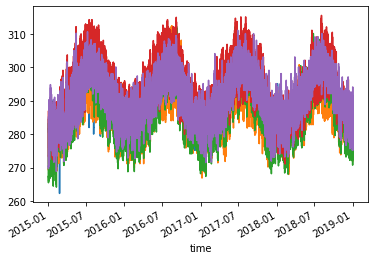

In [16]:
weather.groupby('city_name')['temp'].plot();